In [1]:
%matplotlib inline
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
def download(url, folder, sha1_hash=None):
    """Download a file to folder and return the local filepath."""

def extract(filename, folder):
    """Extract a zip/tar file into folder."""

In [3]:
class KaggleHouse(d2l.DataModule):
    def __init__(self, batch_size, train=None, val=None):
        super().__init__()
        self.save_hyperparameters()
        if self.train is None:
            self.raw_train = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_train.csv', self.root,
                sha1_hash='585e9cc93e70b39160e7921475f9bcd7d31219ce'))
            self.raw_val = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_test.csv', self.root,
                sha1_hash='fa19780a7b011d9b009e8bff8e99922a8ee2eb90'))

In [4]:
data = KaggleHouse(batch_size=64)
print(data.raw_train.shape)
print(data.raw_val.shape)

(1460, 81)
(1459, 80)


In [5]:
print(data.raw_train.iloc[:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [6]:
@d2l.add_to_class(KaggleHouse)
def preprocess(self):
    # Remove the ID and label columns
    label = 'SalePrice'
    features = pd.concat(
        (self.raw_train.drop(columns=['Id', label]),
         self.raw_val.drop(columns=['Id'])))
    # Standardize numerical columns
    numeric_features = features.dtypes[features.dtypes!='object'].index
    features[numeric_features] = features[numeric_features].apply(
        lambda x: (x - x.mean()) / (x.std()))
    # Replace NAN numerical features by 0
    features[numeric_features] = features[numeric_features].fillna(0)
    # Replace discrete features by one-hot encoding
    features = pd.get_dummies(features, dummy_na=True)
    # Save preprocessed features
    self.train = features[:self.raw_train.shape[0]].copy()
    self.train[label] = self.raw_train[label]
    self.val = features[self.raw_train.shape[0]:].copy()

''' 
这段代码定义了一个名为`preprocess`的函数，用于预处理Kaggle房价预测任务的数据。该函数主要执行以下操作：

1. 删除ID和标签列：从原始训练集和验证集中删除ID列和'SalePrice'标签列，将剩余的特征组合在一起。

2. 标准化数值特征：找到数值型特征（即不是对象类型的特征），并对它们进行标准化。标准化是将每个特征减去其均值并除以其标准差，从而使特征具有零均值和单位方差。

3. 用0替换缺失的数值特征：将数值特征中的NaN值替换为0。

4. 用one-hot编码替换离散特征：将离散特征转换为one-hot编码表示。`pd.get_dummies`函数可以自动找到离散特征并创建one-hot编码。`dummy_na=True`表示对于具有NaN值的特征，也创建一个表示缺失值的新列。

5. 保存预处理后的特征：将预处理后的特征分为训练集和验证集，并将'SalePrice'标签列添加回训练集。

这个预处理函数的目的是为了在训练模型之前清洗和准备数据。通过标准化数值特征、处理缺失值和将离散特征转换为one-hot编码，我们可以确保模型接收到适当格式的输入数据。
'''

" \n这段代码定义了一个名为`preprocess`的函数，用于预处理Kaggle房价预测任务的数据。该函数主要执行以下操作：\n\n1. 删除ID和标签列：从原始训练集和验证集中删除ID列和'SalePrice'标签列，将剩余的特征组合在一起。\n\n2. 标准化数值特征：找到数值型特征（即不是对象类型的特征），并对它们进行标准化。标准化是将每个特征减去其均值并除以其标准差，从而使特征具有零均值和单位方差。\n\n3. 用0替换缺失的数值特征：将数值特征中的NaN值替换为0。\n\n4. 用one-hot编码替换离散特征：将离散特征转换为one-hot编码表示。`pd.get_dummies`函数可以自动找到离散特征并创建one-hot编码。`dummy_na=True`表示对于具有NaN值的特征，也创建一个表示缺失值的新列。\n\n5. 保存预处理后的特征：将预处理后的特征分为训练集和验证集，并将'SalePrice'标签列添加回训练集。\n\n这个预处理函数的目的是为了在训练模型之前清洗和准备数据。通过标准化数值特征、处理缺失值和将离散特征转换为one-hot编码，我们可以确保模型接收到适当格式的输入数据。\n"

In [7]:
data.preprocess()
data.train.shape

(1460, 331)

In [8]:
@d2l.add_to_class(KaggleHouse)
def get_dataloader(self, train):
    label = 'SalePrice'
    data = self.train if train else self.val
    if label not in data: return
    get_tensor = lambda x: torch.tensor(x.values.astype(float),
                                      dtype=torch.float32)
    # Logarithm of prices
    tensors = (get_tensor(data.drop(columns=[label])),  # X
               torch.log(get_tensor(data[label])).reshape((-1, 1)))  # Y
    return self.get_tensorloader(tensors, train)

''' 
  这段代码定义了一个名为`get_dataloader`的函数，用于为Kaggle房价预测任务的数据生成数据加载器。该函数根据输入参数`train`的值，为训练集或验证集创建一个PyTorch数据加载器。

1. 首先，根据`train`参数选择要处理的数据集（训练集或验证集）。如果数据集中没有标签列（'SalePrice'），则返回None。

2. 定义一个名为`get_tensor`的辅助函数，用于将Pandas DataFrame数据转换为PyTorch张量。这个函数接受一个DataFrame对象，将其值转换为浮点数，并创建一个相应的PyTorch张量。

3. 使用`get_tensor`函数创建输入特征（X）和目标变量（Y）的张量。对于目标变量（房价），我们对其值取对数，以便在训练过程中更好地处理不同数量级的房价。将房价张量Y调整为列向量。

4. 调用`self.get_tensorloader`函数，为给定的输入特征和目标变量张量创建一个PyTorch数据加载器。这个加载器将用于在训练和评估模型时批量加载数据。

这个`get_dataloader`函数的目的是简化从预处理过的数据集中获取数据的过程。通过为训练集和验证集创建数据加载器，我们可以轻松地在训练和评估模型时批量加载数据。
'''

" \n  这段代码定义了一个名为`get_dataloader`的函数，用于为Kaggle房价预测任务的数据生成数据加载器。该函数根据输入参数`train`的值，为训练集或验证集创建一个PyTorch数据加载器。\n\n1. 首先，根据`train`参数选择要处理的数据集（训练集或验证集）。如果数据集中没有标签列（'SalePrice'），则返回None。\n\n2. 定义一个名为`get_tensor`的辅助函数，用于将Pandas DataFrame数据转换为PyTorch张量。这个函数接受一个DataFrame对象，将其值转换为浮点数，并创建一个相应的PyTorch张量。\n\n3. 使用`get_tensor`函数创建输入特征（X）和目标变量（Y）的张量。对于目标变量（房价），我们对其值取对数，以便在训练过程中更好地处理不同数量级的房价。将房价张量Y调整为列向量。\n\n4. 调用`self.get_tensorloader`函数，为给定的输入特征和目标变量张量创建一个PyTorch数据加载器。这个加载器将用于在训练和评估模型时批量加载数据。\n\n这个`get_dataloader`函数的目的是简化从预处理过的数据集中获取数据的过程。通过为训练集和验证集创建数据加载器，我们可以轻松地在训练和评估模型时批量加载数据。\n"

In [9]:
def k_fold_data(data, k):
    rets = []
    fold_size = data.train.shape[0] // k
    for j in range(k):
        idx = range(j * fold_size, (j+1) * fold_size)
        rets.append(KaggleHouse(data.batch_size, data.train.drop(index=idx),
                                data.train.loc[idx]))
    return rets
''' 
这段代码定义了一个名为`k_fold_data`的函数，用于将数据划分为k个子集，以进行k折交叉验证。函数接收两个参数：`data`是一个包含训练数据的对象（例如`KaggleHouse`实例），`k`是要创建的子集数。函数的主要步骤如下：

1. 初始化一个空列表`rets`，用于存储k个子集的数据。

2. 计算每个子集的大小`fold_size`，将训练集的大小除以k并取整。

3. 使用for循环，将数据划分为k个子集。在每次迭代中：
   - 计算当前子集的索引范围`idx`。
   - 使用`data.train.drop(index=idx)`从原始训练集中删除当前子集的数据，将剩余数据作为新训练集。
   - 使用`data.train.loc[idx]`从原始训练集中提取当前子集的数据，将其作为新的验证集。
   - 使用新的训练集和验证集创建一个`KaggleHouse`实例，并将其添加到`rets`列表中。

4. 返回包含k个子集数据的列表`rets`。

这个`k_fold_data`函数的目的是为了在训练模型时使用k折交叉验证。通过将数据划分为k个子集，我们可以在k次迭代中使用不同的子集作为验证集，从而更全面地评估模型的性能。这有助于减少模型在特定数据划分上的过拟合，提高模型的泛化能力。
'''

' \n这段代码定义了一个名为`k_fold_data`的函数，用于将数据划分为k个子集，以进行k折交叉验证。函数接收两个参数：`data`是一个包含训练数据的对象（例如`KaggleHouse`实例），`k`是要创建的子集数。函数的主要步骤如下：\n\n1. 初始化一个空列表`rets`，用于存储k个子集的数据。\n\n2. 计算每个子集的大小`fold_size`，将训练集的大小除以k并取整。\n\n3. 使用for循环，将数据划分为k个子集。在每次迭代中：\n   - 计算当前子集的索引范围`idx`。\n   - 使用`data.train.drop(index=idx)`从原始训练集中删除当前子集的数据，将剩余数据作为新训练集。\n   - 使用`data.train.loc[idx]`从原始训练集中提取当前子集的数据，将其作为新的验证集。\n   - 使用新的训练集和验证集创建一个`KaggleHouse`实例，并将其添加到`rets`列表中。\n\n4. 返回包含k个子集数据的列表`rets`。\n\n这个`k_fold_data`函数的目的是为了在训练模型时使用k折交叉验证。通过将数据划分为k个子集，我们可以在k次迭代中使用不同的子集作为验证集，从而更全面地评估模型的性能。这有助于减少模型在特定数据划分上的过拟合，提高模型的泛化能力。\n'

In [10]:
# Concise Implementation
class MyLinearRegression(d2l.Module):
    """The linear regression model implemented with high-level APIs.

    Defined in :numref:`sec_linear_concise`"""
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(            
            nn.Flatten(), nn.LazyLinear(256), nn.BatchNorm1d(256), nn.ReLU(),
            nn.Dropout(0.3), nn.LazyLinear(128), nn.BatchNorm1d(128), nn.ReLU(),
            nn.Dropout(0.3), nn.LazyLinear(64), nn.BatchNorm1d(64), nn.ReLU(),
            nn.Dropout(0.3), nn.LazyLinear(1))
        #self.net.weight.data.normal_(0, 0.01)
        #self.net.bias.data.fill_(0)

    def forward(self, X):
        """Defined in :numref:`sec_linear_concise`"""
        return self.net(X)

    def loss(self, y_hat, y):
        """Defined in :numref:`sec_linear_concise`"""
        fn = nn.MSELoss()
        return fn(y_hat, y)

    def configure_optimizers(self):
        """Defined in :numref:`sec_linear_concise`"""
        # return torch.optim.SGD(self.parameters(), self.lr)
        return torch.optim.Adam(self.parameters(), self.lr)

    def get_w_b(self):
        """Defined in :numref:`sec_linear_concise`"""
        return (self.net.weight.data, self.net.bias.data)

def k_fold(trainer, data, k, lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = MyLinearRegression(lr)
        model.board.yscale='log'
        # self.board = d2l.LiveLossPlot()
        # model.board.yscale='linear'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'average validation log mse = {sum(val_loss)/len(val_loss)}')
    return models

/data2/miniconda3/envs/d2l-pytorch/lib/python3.8/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/data2/miniconda3/envs/d2l-pytorch/lib/python3.8/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/data2/miniconda3/envs/d2l-pytorch/lib/python3.8/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/data2/miniconda3/envs/d2l-pytorch/lib/python3.8/site-packages/torch/nn/modules/lazy.py:180: UserWar

average validation log mse = 0.03347167195752264


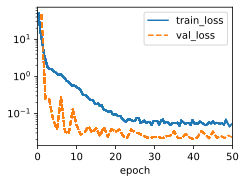

In [11]:
trainer = d2l.Trainer(max_epochs=50)
models = k_fold(trainer, data, k=10, lr=0.4)

In [12]:
preds = [model(torch.tensor(data.val.values.astype(float), dtype=torch.float32))
         for model in models]
# Taking exponentiation of predictions in the logarithm scale
ensemble_preds = torch.exp(torch.cat(preds, 1)).mean(1)
submission = pd.DataFrame({'Id':data.raw_val.Id,
                           'SalePrice':ensemble_preds.detach().numpy()})
submission.to_csv('submission.csv', index=False)